In [1]:
# Check if running on colab
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# pip install any missing packages
if IN_COLAB:
  !pip install equadratures # for standard pip install
  #!pip install git+https://github.com/Effective-Quadratures/Effective-Quadratures.git@master # for specific branch

import numpy as np                                                                                                                                                                                      
import matplotlib.pyplot as plt
from equadratures import *

Define the function and training data:

In [2]:
our_function = lambda x:  0.3*x**4 -1.6*x**3 +0.6*x**2 +2.4*x - 0.5

In [43]:
N = 8 # number of training points (note, some will be removed below)
n = 3 # degree of polynomial

In [44]:
x = np.sort((2*np.random.rand(N,1)-1),axis=0)
noise_var = 0.05
y = our_function(x) + np.random.randn(N,1)*np.sqrt(noise_var)
pos = ((x>0)*(x<0.3)).nonzero()[0]
x = np.delete(x,pos)[:,None].squeeze()
y = np.delete(y,pos)[:,None].squeeze()

N = len(x)

dimensions = 1
if N < n: quit('N must exceed n')

Fit a polynomial approximation with Effective Quadratures.

In [45]:
param = Parameter(distribution='Uniform', lower=np.min(x), upper=np.max(x), order=n)
myParameters = [param for i in range(dimensions)] # one-line for loop for parameters
myBasis = Basis('Univariate')
poly = Poly(myParameters, myBasis, method='least-squares', sampling_args={'sample-points':x.reshape(-1,1), 'sample-outputs':y.reshape(-1,1)} )
poly.set_model()

At 500 test points from $\tilde{x}=-1.5$ to $\tilde{x}=1.5$, obtain the polynomial approximation
$$
\begin{align}
\tilde{\mathbf{y}} &= \tilde{\mathbf{x}}^T \left( \mathbf{X}^T\mathbf{X} \right)^{-1}\mathbf{X}^T\mathbf{y} \\
&= \tilde{\boldsymbol{x}}^T\hat{\mathbf{w}}
\end{align}
$$
and the polynomial variance
$$
\tilde{\sigma}^2 = \sigma^2 \tilde{\mathbf{x}}^T \left( \mathbf{X}^T\mathbf{X} \right)^{-1} \tilde{\mathbf{x}}
$$

In [46]:
xtest = np.linspace(-1.5, 1.5, 500)
w = poly.get_coefficients() 
xtestb = poly.get_poly(xtest.reshape(-1,1))
xb     = poly.get_poly(x.reshape(-1,1))
ytest = np.dot(xtestb.T,w).flatten()
sigma2 = 0.01 #((y.reshape(-1,1) - poly.get_polyfit(x))**2).mean()
xtestb = xtestb.T
xb = xb.T
testvar = np.diag(sigma2*np.dot(np.dot(xtestb,np.linalg.inv(np.dot(xb.T,xb))),xtestb.T))[:,None]  
std = np.sqrt(testvar).flatten()*1.96

For comparison, do the same with the covariance matrix returned by numpy `polyfit`.

In [47]:
# numpy
p, C_p = np.polyfit(x, y, n, cov=True)  # C_z is estimated covariance matrix
C_p = 0.01
# Matrix with rows 1, t, t**2, ...:
TT = np.vstack([xtest**(n-i) for i in range(n+1)]).T
ytest_np = np.dot(TT, p)  # matrix multiplication calculates the polynomial values
C_yi = np.dot(TT, np.dot(C_p, TT.T)) # C_y = TT*C_z*TT.T
std_np = np.sqrt(np.diag(C_yi))*1.96  # Standard deviations are sqrt of diagonal

Now plot everything!

[]

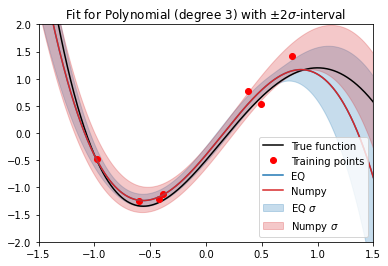

In [48]:
fg, ax = plt.subplots(1, 1)
ax.set_title("Fit for Polynomial (degree {}) with $\pm2\sigma$-interval".format(n))

ax.plot(xtest,our_function(xtest),'-k',label='True function')
ax.plot(x, y, 'ro',label='Training points')
ax.fill_between(xtest, ytest+std, ytest-std, alpha=.25,color='C0',label='EQ $\sigma$')
ax.plot(xtest, ytest,'-C0',label='EQ')
ax.fill_between(xtest, ytest_np+std_np, ytest_np-std_np, alpha=.25,color='C3',label='Numpy $\sigma$')
ax.plot(xtest, ytest,'-C3',label='Numpy')

ax.axis('tight')
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-2,2])
ax.legend()
plt.plot()

0.01 0.01


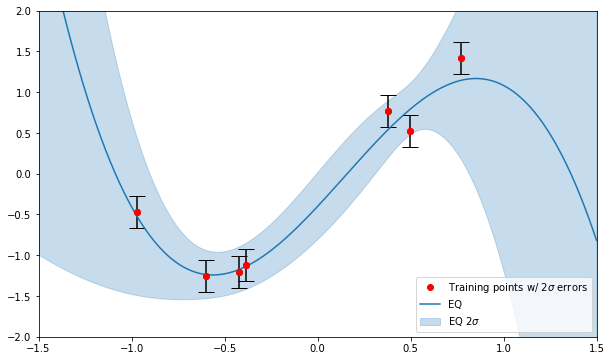

In [49]:
from copy import deepcopy

# Now what if we had a covariance matrix of noise?
#noise_variance = np.random.rand(N) * 0.01
#noise_variance[0] =  10. * noise_variance[0] # amplifing the noise associated with some values!
#noise_variance[32] = 13. * noise_variance[32]

noise_variance = np.ones(N)*sigma2
print(np.min(noise_variance),np.max(noise_variance))

Sigma = np.diag(noise_variance) # a diagonal matrix need not be assumed.

def inv(M):
  """
  M: numpy matrix.
  """
  ll, mm = M.shape
  M2 = deepcopy(M) + 1e-10 * np.eye(ll)
  L = np.linalg.cholesky(M2)
  inv_L = np.linalg.inv(L)
  inv_M = inv_L.T @ inv_L
  return inv_M

# On the training data! 
P = poly.get_poly(poly._quadrature_points)
W = np.diag(np.sqrt(poly._quadrature_weights))
A = np.dot(W, P.T)
Q = np.dot( inv( np.dot(A.T, A) ), A.T)

# On the testing data (omit weights!)
testing_points = xtest.reshape(-1,1)
Po = poly.get_poly(testing_points)
Ao = Po.T

# Propagating the uncertainties!
Sigma_X = np.dot( np.dot(Q, Sigma), Q.T)
Sigma_F = np.dot( np.dot(Ao, Sigma_X), Ao.T) 
two_std_F = 1.96 * np.sqrt( np.diag(Sigma_F) )

# Plot!
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111)
ax.plot(x, y, 'ro',label='Training points w/ 2$\sigma$ errors')
ax.errorbar(x, y, 1.96 * np.sqrt(noise_variance), fmt='ro', ecolor='k', capthick=1, capsize=8)
ax.fill_between(xtest, ytest+two_std_F, ytest-two_std_F, alpha=.25,color='C0',label='EQ 2$\sigma$')
ax.plot(xtest, ytest,'-C0',label='EQ')
ax.axis('tight')
ax.set_xlim([-1.5,1.5])
ax.set_ylim([-2,2])
ax.legend()
plt.show()